# ***MAIN FUNCTIONALITY***

In [48]:
import pandas as pd
import plotly.express as px
import seaborn as sns

from meteo.Site import Site
from solar.SolarPVPanel import SolarPVPanel
from solar.SolarPVArray import SolarPVArray
from solar.SolarPVModel import SolarPVModel

from misc.log_config import configure_logging
from misc.util import load_pv_model

configure_logging()
pd.options.display.float_format = '{:.3f}'.format

# Set up site location and get TMY data
name = ""
address = "York St, Belfast, BT15 1ED"
client = "Ulster University"

site = Site(name=name, 
            address=address, 
            client=client, 
            latitude=54.60452, 
            longitude=-5.92860, 
            size=100)

# Set up PV panel being used
panel_kwp = 0.3538
size_m2 = 1.990
eff = 0.2237
cell_temp_coeff = -0.004
cell_NOCT = 48
lifespan = 25
pv_eol_derating = 0.88
refraction_index = 0.05

pv_panel = SolarPVPanel(panel_kwp, size_m2, eff, cell_temp_coeff, 
                        cell_NOCT, lifespan, pv_eol_derating, refraction_index)


# Set up PV arrays
num_pv_panels = 4
surface_pitch = 35
surface_azimuth = 0
albedo = 0.2
cost_per_kWp = 1250

pv_array_1 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, surface_azimuth, albedo, cost_per_kWp)
pv_array_2 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, surface_azimuth, albedo, cost_per_kWp)
pv_array_3 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, surface_azimuth, albedo, cost_per_kWp)
pv_array_4 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, surface_azimuth, albedo, cost_per_kWp)
pv_array_5 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, surface_azimuth, albedo, cost_per_kWp)

pv_arrays = [pv_array_1, pv_array_2, pv_array_3, pv_array_4, pv_array_5]


# Run the model
pv_model = SolarPVModel(site, pv_arrays)

# Save model as .wmm file
pv_model.save_model()

# Load .wwm model from file
pv_model = load_pv_model()

print("")
print(f"{sum(array.pv_kwp for array in pv_model.arrays)}kWp Solar PV modelled covering a {sum(array.area_m2 for array in pv_model.arrays)}m2 area.")


2024-02-22 16:21:48,729 - INFO - Fetching TMY data for latitude: 54.60452, longitude: -5.9286
2024-02-22 16:21:48,730 - INFO - TMY data obtained for: 54.60452, longitude: -5.9286
2024-02-22 16:21:48,730 - INFO - *******************
2024-02-22 16:21:48,731 - INFO - Solar PV Panel created: Size: 0.3538kW, Size: 1.99m2, Efficiency: 0.2237%, Lifespan: 25yrs
2024-02-22 16:21:48,731 - INFO - Solar PV array created: Size: 1.415kW, Size: 7.96m2,Azimuth: 0deg, Lifespan: 25yrs,Pitch: 35deg, Efficiency: 0.2237%
2024-02-22 16:21:48,732 - INFO - Solar PV array created: Size: 1.415kW, Size: 7.96m2,Azimuth: 0deg, Lifespan: 25yrs,Pitch: 35deg, Efficiency: 0.2237%
2024-02-22 16:21:48,732 - INFO - Solar PV array created: Size: 1.415kW, Size: 7.96m2,Azimuth: 0deg, Lifespan: 25yrs,Pitch: 35deg, Efficiency: 0.2237%
2024-02-22 16:21:48,733 - INFO - Solar PV array created: Size: 1.415kW, Size: 7.96m2,Azimuth: 0deg, Lifespan: 25yrs,Pitch: 35deg, Efficiency: 0.2237%
2024-02-22 16:21:48,733 - INFO - Solar PV ar


7.075kWp Solar PV modelled covering a 39.8m2 area.


In [2]:
pv_model.summary

PV_Gen_kWh_Annual                7197.494
PV_Gen_kWh_Lifetime            168709.256
E_POA_Wm2_Annual              5205164.050
Panel_POA_Wm2_Annual          5145343.692
IAM_Loss_Wm2_Annual             59820.359
PV_Thermal_Loss_kWh_Annual         66.191
E_Beam_Wm2_Annual             2532208.524
E_Diffuse_Wm2_Annual          2587621.031
E_Ground_Wm2_Annual             85334.496
ET_HRad_Wm2_Annual           11352896.361
Array_Temp_C_Avg                   11.526
T2m_Avg                             8.899
dtype: float64

# ***Temperature Tests***

In [3]:
import math

def calc_array_temp_homer(
    e_poa,
    ambient_temp,
    cell_temp_coeff=-0.0035,
    electrical_eff=0.21,
    cell_NOCT=42,
    ambient_NOCT=20,
    e_poa_NOCT=800,
    cell_temp_STC=25,
    transmittance_absorptance=0.9,
):
    """Calculates the cell temperature of a PV panel.

    Parameters:
    - e_poa: Plane of array irradiance in kW/m^2.
    - ambient_temp: Ambient temperature in degrees Celsius.
    - cell_temp_coeff: Temperature coefficient of the PV cell.
    - electrical_eff: Electrical efficiency of the PV panel.
    - cell_NOCT, ambient_NOCT: Nominal operating cell temperature and the corresponding ambient temperature.
    - e_poa_NOCT: Irradiance at NOCT conditions in W/m^2.
    - cell_temp_STC: Cell temperature at standard test conditions in degrees Celsius.
    - transmittance_absorptance: Transmittance and absorptance product of the PV panel.

    Returns:
    - Cell temperature of the PV panel.
    """
    temp_factor = (cell_NOCT - ambient_NOCT) * ((e_poa * 1000) / e_poa_NOCT)
    numerator = ambient_temp + temp_factor * (
        1
        - (electrical_eff * (1 - cell_temp_coeff * cell_temp_STC))
        / transmittance_absorptance
    )
    denominator = 1 + temp_factor * (
        cell_temp_coeff * electrical_eff / transmittance_absorptance
    )

    return numerator / denominator


def calc_array_temp_pvsyst(e_poa, ambient_temp, windspeed, uc=29, uv=1.2):
    u = uc + (uv * windspeed)
    tcell = ambient_temp + (1/u) * (0.9 * e_poa * 1000 * (1-0.21))
    return tcell

def calc_array_temp_sandia(e_poa: float, ambient_temp: float, wind_speed: float, 
                           a: float = -3.47, b: float = -0.0594) -> float:
    """
    Calculate the temperature of a photovoltaic (PV) array based on the Sandia method.
    
    Parameters:
    - e_poa (float): Plane of array irradiance in kW/m^2. Represents the solar irradiance incident on the PV array.
    - ambient_temp (float): Ambient temperature in degrees Celsius.
    - wind_speed (float): Wind speed in m/s at the site of the PV array.
    - a (float): Coefficient a in the exponential model, defaulting to -3.47.
    - b (float): Coefficient b in the exponential model, defaulting to -0.0594.
    
    Returns:
    - float: Estimated temperature of the PV array in degrees Celsius.
    """
    array_temp = e_poa * 1000 * math.exp(a + b * wind_speed) + ambient_temp
    return array_temp

def calc_array_temp_faiman(e_poa, ambient_temp, wind_speed, U_0=25, U_1=6.84):
    array_temp = ambient_temp + (e_poa * 1000 / (U_0 + U_1 * wind_speed))
    return array_temp


# Example usage:
e_poa=0.5
ambient_temp=25
wind_speed=1

list_1 = []
list_2 = []
list_3 = []
list_4 = []
list_5 = []


print("")
wind_speed=10
for i in range(1):
    cell_temperature = calc_array_temp_homer(e_poa, ambient_temp)
    print(f"The cell temperature is {cell_temperature:.2f}°C from the Homer model with {wind_speed}m/s windspeed")
    list_2.append(cell_temperature)
    wind_speed += 1

print("")
wind_speed=0
for i in range(21):
    cell_temperature = calc_array_temp_pvsyst(e_poa, ambient_temp, wind_speed)
    print(f"The cell temperature is {cell_temperature:.2f}°C from the PVSyst model with {wind_speed}m/s windspeed")
    list_3.append(cell_temperature)
    wind_speed += 1

print("")
wind_speed=0
for i in range(21):
    cell_temperature = calc_array_temp_sandia(e_poa, ambient_temp, wind_speed)
    print(f"The cell temperature is {cell_temperature:.2f}°C from the Sandia model with {wind_speed}m/s windspeed")
    list_4.append(cell_temperature)
    wind_speed += 1

print("")
wind_speed=0
for i in range(21):
    cell_temperature = calc_array_temp_faiman(e_poa, ambient_temp, wind_speed)
    print(f"The cell temperature is {cell_temperature:.2f}°C from the Faiman model with {wind_speed}m/s windspeed")
    list_5.append(cell_temperature)
    wind_speed += 1



The cell temperature is 35.66°C from the Homer model with 10m/s windspeed

The cell temperature is 37.26°C from the PVSyst model with 0m/s windspeed
The cell temperature is 36.77°C from the PVSyst model with 1m/s windspeed
The cell temperature is 36.32°C from the PVSyst model with 2m/s windspeed
The cell temperature is 35.90°C from the PVSyst model with 3m/s windspeed
The cell temperature is 35.52°C from the PVSyst model with 4m/s windspeed
The cell temperature is 35.16°C from the PVSyst model with 5m/s windspeed
The cell temperature is 34.82°C from the PVSyst model with 6m/s windspeed
The cell temperature is 34.51°C from the PVSyst model with 7m/s windspeed
The cell temperature is 34.21°C from the PVSyst model with 8m/s windspeed
The cell temperature is 33.93°C from the PVSyst model with 9m/s windspeed
The cell temperature is 33.67°C from the PVSyst model with 10m/s windspeed
The cell temperature is 33.42°C from the PVSyst model with 11m/s windspeed
The cell temperature is 33.19°C fr

In [4]:
%%timeit
cell_temperature = calc_array_temp_faiman(e_poa, ambient_temp, wind_speed)

193 ns ± 2.11 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [5]:
%%timeit
cell_temperature = calc_array_temp_sandia(e_poa, ambient_temp, wind_speed)

226 ns ± 1.13 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [6]:
%%timeit
cell_temperature = calc_array_temp_pvsyst(e_poa, ambient_temp, wind_speed)

255 ns ± 0.783 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [7]:
%%timeit
cell_temperature = calc_array_temp_homer(e_poa, ambient_temp)

422 ns ± 8.04 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [8]:
import numpy as np
import plotly.express as px

# Define the modified logistic function
def calc_low_light_losses(pv_kwp, e_poa, k=0.0065, midpoint=75):
    """
    Modified logistic function to calculate efficiency based on irradiance,
    with a minimum efficiency level.

    Parameters:
    pv_kwp (float): The rated solar PV size (kWp).
    e_poa (float): The irradiance incident on array (W/m2).
    k (float): The steepness of the curve.
    midpoint (float): The irradiance at which the efficiency is at its midpoint.

    Returns:
    float: The calculated efficiency at the given irradiance.
    """
    pv_kwp_min = pv_kwp * 0.6
    eff = pv_kwp_min + (pv_kwp - pv_kwp_min) / (1 + np.exp(-k * (e_poa - midpoint)))
    return eff


# Generate a range of irradiance values from 0 to 1000 W/m2 and set L to 1 kWp
L = 1
irradiance_range = np.linspace(0, 1000, 1001)
efficiencies = calc_low_light_losses(L, irradiance_range)

# Plot Graph of results
fig = px.line(efficiencies[:], y=efficiencies[:], x = irradiance_range[:])

fig.update_layout(xaxis_title="Irradiation (W/m2)", yaxis_title="kWp Output",
                  title = "Line graph showing PV kWp output due to low irradiance losses")

In [9]:
calc_low_light_losses(1, 300)

0.9247658981999034

In [10]:
px.line(pv_model.combined_model.E_POA_Wm2_Total)

# ***Performance Test***

In [11]:
# Performance Testing
# import pstats
# import cProfile
# from meteo.Site import Site
# from solar.SolarPVPanel import SolarPVPanel
# from solar.SolarPVArray import SolarPVArray
# from solar.SolarPVModel import SolarPVModel
# from misc.log_config import configure_logging
# from misc.util import load_pv_model
# configure_logging()
# cProfile.run("SolarPVModel(site=Site(latitude=54.60452, longitude=-5.92860, size=100), arrays=[SolarPVArray(SolarPVPanel(), 4), SolarPVArray(SolarPVPanel(), 4), SolarPVArray(SolarPVPanel(), 4), SolarPVArray(SolarPVPanel(), 4), SolarPVArray(SolarPVPanel(), 4)])", 'performance_test.prof')
# p = pstats.Stats('performance_test.prof')
# p.sort_stats('tottime').print_stats()
# p.sort_stats('cumtime').print_stats()

# ***Example Running Model with variable inputs***

In [12]:
# %%timeit

import pandas as pd
import plotly.express as px
import seaborn as sns

from meteo.Site import Site
from solar.SolarPVPanel import SolarPVPanel
from solar.SolarPVArray import SolarPVArray
from solar.SolarPVModel import SolarPVModel

from misc.log_config import configure_logging
from misc.util import load_pv_model

configure_logging()
pd.options.display.float_format = '{:.3f}'.format

# Set up site location and get TMY data
name = ""
address = "York St, Belfast, BT15 1ED"
client = "Ulster University"

site = Site(name=name, 
            address=address, 
            client=client, 
            latitude=54.60452, 
            longitude=-5.92860, 
            size=100)

2024-02-22 16:18:30,807 - INFO - Fetching TMY data for latitude: 54.60452, longitude: -5.9286
2024-02-22 16:18:30,808 - INFO - TMY data obtained for: 54.60452, longitude: -5.9286
2024-02-22 16:18:30,808 - INFO - *******************


In [13]:
# %%timeit

# Set up PV panel being used
pv_panel = SolarPVPanel()

# Set up PV arrays
num_pv_panels = 4
surface_pitch = 35
surface_azimuth = -90
albedo = 0.2
cost_per_kWp = 1250

pv_array_1 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, surface_azimuth, albedo, cost_per_kWp)
pv_array_2 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, -45)
pv_array_3 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, 0)
pv_array_4 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, 45)
pv_array_5 = SolarPVArray(pv_panel, num_pv_panels, surface_pitch, 90)

pv_arrays = [pv_array_1, pv_array_2, pv_array_3, pv_array_4, pv_array_5]

# Run the model
pv_model = SolarPVModel(site, pv_arrays)

print("")
print(f"{sum(array.pv_kwp for array in pv_model.arrays)}kWp Solar PV modelled")


2024-02-22 16:18:30,817 - INFO - Solar PV Panel created: Size: 0.3538kW, Size: 1.99m2, Efficiency: 0.2237%, Lifespan: 25yrs
2024-02-22 16:18:30,818 - INFO - Solar PV array created: Size: 1.415kW, Size: 7.96m2,Azimuth: -90deg, Lifespan: 25yrs,Pitch: 35deg, Efficiency: 0.2237%
2024-02-22 16:18:30,819 - INFO - Solar PV array created: Size: 1.415kW, Size: 7.96m2,Azimuth: -45deg, Lifespan: 25yrs,Pitch: 35deg, Efficiency: 0.2237%
2024-02-22 16:18:30,819 - INFO - Solar PV array created: Size: 1.415kW, Size: 7.96m2,Azimuth: 0deg, Lifespan: 25yrs,Pitch: 35deg, Efficiency: 0.2237%
2024-02-22 16:18:30,820 - INFO - Solar PV array created: Size: 1.415kW, Size: 7.96m2,Azimuth: 45deg, Lifespan: 25yrs,Pitch: 35deg, Efficiency: 0.2237%
2024-02-22 16:18:30,821 - INFO - Solar PV array created: Size: 1.415kW, Size: 7.96m2,Azimuth: 90deg, Lifespan: 25yrs,Pitch: 35deg, Efficiency: 0.2237%
2024-02-22 16:18:30,821 - INFO - *******************
2024-02-22 16:18:30,822 - INFO - Starting Solar PV model simulation


7.075kWp Solar PV modelled


In [14]:
import plotly.express as px

px.bar(pv_model.summary_grouped.hourly[["PV_Gen_kWh_Total", "IAM_Loss_Wm2_Total", "PV_Thermal_Loss_kWh_Total"]])

In [15]:
px.bar(pv_model.summary_grouped.monthly[["E_Beam_Wm2_Total", "E_Diffuse_Wm2_Total", "E_Ground_Wm2_Total"]])

In [16]:
px.line(pv_model.models[0]["model_result"][["Array_Temp_C", "T2m"]])

In [17]:
px.line(pv_model.summary_grouped.monthly[["ET_HRad_Wm2_Total", "E_POA_Wm2_Total", "Panel_POA_Wm2_Total"]])

In [18]:
pv_model.summary

PV_Gen_kWh_Annual                6616.109
PV_Gen_kWh_Lifetime            155081.589
E_POA_Wm2_Annual              4781110.369
Panel_POA_Wm2_Annual          4723037.178
IAM_Loss_Wm2_Annual             58073.191
PV_Thermal_Loss_kWh_Annual         51.480
E_Beam_Wm2_Annual             2108154.842
E_Diffuse_Wm2_Annual          2587621.031
E_Ground_Wm2_Annual             85334.496
ET_HRad_Wm2_Annual           11352896.361
Array_Temp_C_Avg                   11.311
T2m_Avg                             8.899
dtype: float64

In [19]:
pv_model.combined_model

,E_Beam_Wm2_Total,E_Diffuse_Wm2_Total,E_Ground_Wm2_Total,E_POA_Wm2_Total,Panel_POA_Wm2_Total,ET_HRad_Wm2_Total,Array_Temp_C_Avg,PV_Gen_kWh_Total,PV_Thermal_Loss_kWh_Total,IAM_Loss_Wm2_Total,Declination_Angle,Solar_Time,Hour_Angle,T2m,Hour_of_Day,Day_of_Year,Week_of_Year,Month_of_Year
0,0.000,0.000,0.000,0.000,0.000,0.000,3.070,0.000,0.000,0.000,-23.012,0.056,-179.155,3.070,0,1,1,1
1,0.000,0.000,0.000,0.000,0.000,0.000,2.630,0.000,0.000,0.000,-23.012,1.056,-164.155,2.630,1,1,1,1
2,0.000,0.000,0.000,0.000,0.000,0.000,2.180,0.000,0.000,0.000,-23.012,2.056,-149.155,2.180,2,1,1,1
3,0.000,0.000,0.000,0.000,0.000,0.000,1.730,0.000,0.000,0.000,-23.012,3.056,-134.155,1.730,3,1,1,1
4,0.000,0.000,0.000,0.000,0.000,0.000,1.280,0.000,0.000,0.000,-23.012,4.056,-119.155,1.280,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.000,0.000,0.000,0.000,0.000,0.000,5.310,0.000,0.000,0.000,-23.086,19.064,105.958,5.310,19,365,52,12
8756,0.000,0.000,0.000,0.000,0.000,0.000,4.860,0.000,0.000,0.000,-23.086,20.064,120.958,4.860,20,365,52,12
8757,0.000,0.000,0.000,0.000,0.000,0.000,4.410,0.000,0.000,0.000,-23.086,21.064,135.958,4.410,21,365,52,12
8758,0.000,0.000,0.000,0.000,0.000,0.000,3.970,0.000,0.000,0.000,-23.086,22.064,150.958,3.970,22,365,52,12


# ***Visualisation***

In [20]:
import plotly.express as px
import seaborn as sns

In [21]:
pv_model.array_model(1).head()

,Hour_of_Day,Day_of_Year,Week_of_Year,Month_of_Year,T2m,Declination_Angle,Solar_Time,Hour_Angle,AOI,Zenith_Angle,...,E_Diffuse_Wm2,E_Ground_Wm2,E_POA_Wm2,Panel_POA_Wm2,IAM_Loss_Wm2,ET_HRad_Wm2,PV_Derated_Eff,Array_Temp_C,PV_Gen_kWh,PV_Thermal_Loss_kWh
0,0,1,1,1,3.070,-23.012,0.056,-179.155,154.774,148.401,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,3.070,0.000,0.000
1,1,1,1,1,2.630,-23.012,1.056,-164.155,141.273,146.257,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2.630,0.000,0.000
2,2,1,1,1,2.180,-23.012,2.056,-149.155,127.880,140.931,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2.180,0.000,0.000
3,3,1,1,1,1.730,-23.012,3.056,-134.155,114.681,133.633,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.730,0.000,0.000
4,4,1,1,1,1.280,-23.012,4.056,-119.155,101.782,125.337,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.280,0.000,0.000


In [22]:
print(f"PV Gen: {round(pv_model.all_models.PV_Gen_kWh_Array_1.sum(), 3)}kWh")
print(f"E POA: {round(pv_model.all_models.E_POA_Wm2_Array_1.sum(), 3)}Whm2")

PV Gen: 1204.633kWh
E POA: 869122.745Whm2


In [23]:
px.bar(pv_model.summary_grouped.hourly[["PV_Gen_kWh_Total", "IAM_Loss_Wm2_Total", "PV_Thermal_Loss_kWh_Total"]])

In [24]:
px.bar(pv_model.summary_grouped.monthly[["PV_Gen_kWh_Total", "IAM_Loss_Wm2_Total", "PV_Thermal_Loss_kWh_Total"]])

In [25]:
px.bar(pv_model.summary_grouped.weekly[["PV_Gen_kWh_Total", "IAM_Loss_Wm2_Total", "PV_Thermal_Loss_kWh_Total"]])

In [26]:
px.bar(pv_model.summary_grouped.daily[["PV_Gen_kWh_Total", "IAM_Loss_Wm2_Total", "PV_Thermal_Loss_kWh_Total"]])

In [27]:
px.line(pv_model.models[0]["model_result"][["Array_Temp_C", "T2m"]])


<Axes: >

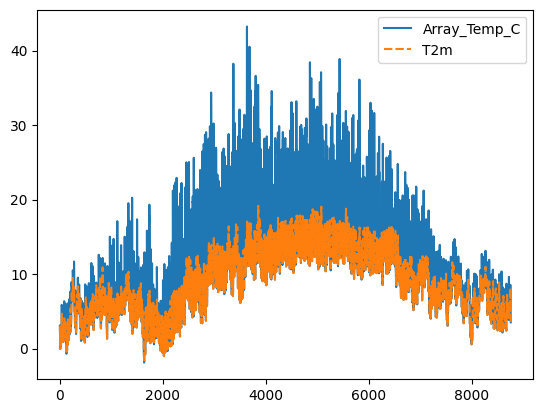

In [28]:
sns.lineplot(pv_model.models[0]["model_result"][["Array_Temp_C", "T2m"]])

In [29]:
px.line(pv_model.models[0]["model_result"][["ET_HRad_Wm2", "E_POA_Wm2"]])

<Axes: >

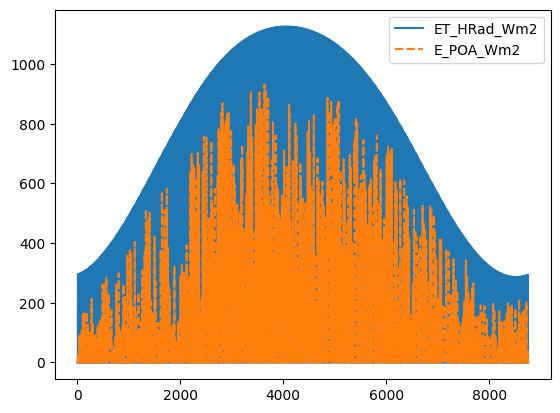

In [30]:
sns.lineplot(pv_model.models[0]["model_result"][["ET_HRad_Wm2", "E_POA_Wm2"]])

# ***VISUAL TESTING***

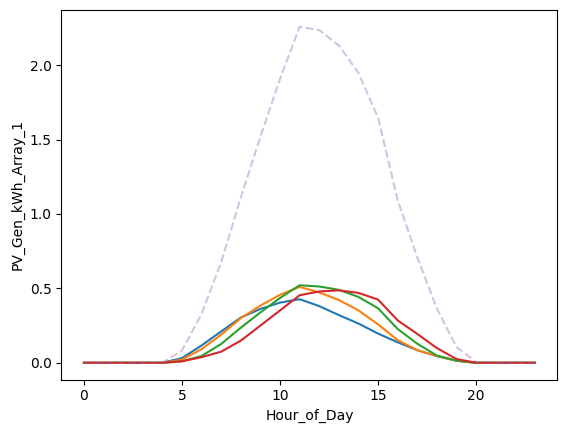

In [31]:
variables = ['E_Beam_Wm2', 'E_Diffuse_Wm2', 'E_Ground_Wm2', 'E_POA_Wm2', 'ET_HRad_Wm2', 
            'Array_Temp_C', 'PV_Gen_kWh', 'AOI', 'Zenith_Angle']

testy = pv_model.all_models

variable = "PV_Gen_kWh"

variable_1 = f"{variable}_Array_1"
variable_2 = f"{variable}_Array_2"
variable_3 = f"{variable}_Array_3"
variable_4 = f"{variable}_Array_4"
variable_7 = f"{variable}_Total"
variable_8 = f"{variable}_Avg"

if variable_1 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_1].mean())
if variable_2 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_2].mean())
if variable_3 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_3].mean())
if variable_4 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_4].mean())
if variable_7 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_7].mean(), alpha=0.4, ls="--")
if variable_8 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_8].mean(), alpha=0.4, ls="--")

<Axes: ylabel='Array_Temp_C_Avg'>

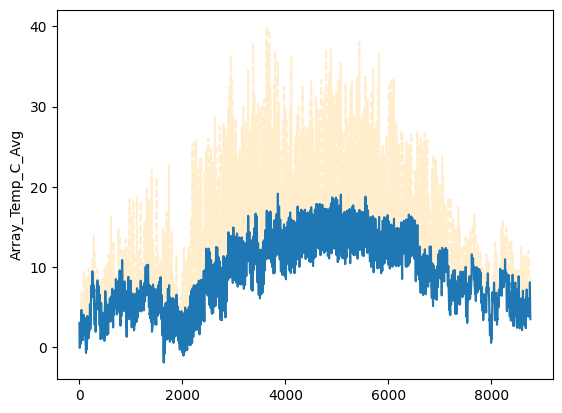

In [32]:
sns.lineplot(pv_model.combined_model["Array_Temp_C_Avg"], alpha = 0.2, ls = "--", color = "orange")
sns.lineplot(pv_model.combined_model["T2m"])

2024-02-22 16:18:32,292 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-22 16:18:32,296 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='Day_of_Year', ylabel='T2m'>

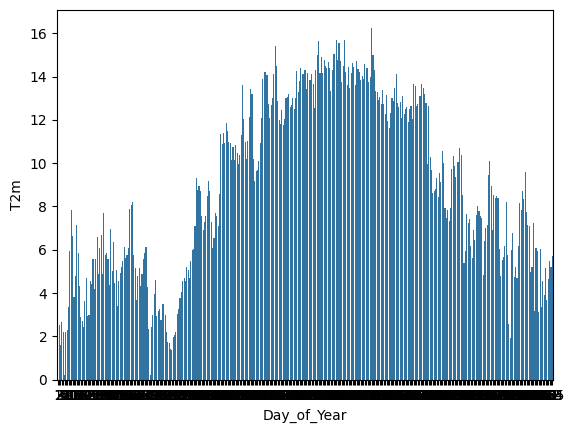

In [33]:
sns.barplot(pv_model.summary_grouped.daily.T2m)

<Axes: xlabel='Hour_of_Day', ylabel='PV_Gen_kWh_Total'>

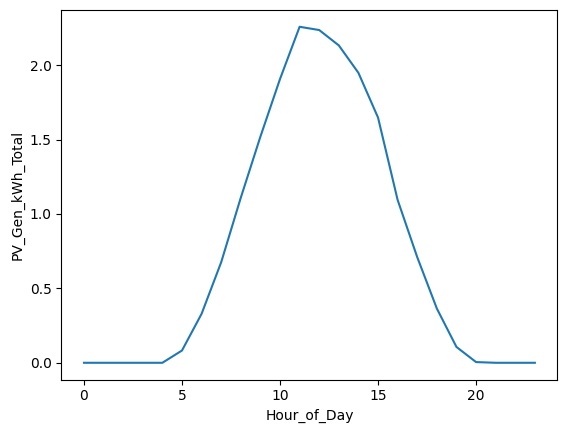

In [34]:
sns.lineplot(pv_model.combined_model.groupby("Hour_of_Day")["PV_Gen_kWh_Total"].mean())

In [35]:
pv_model.all_models["PV_Gen_kWh_Total"].sum()

6616.10873549204

In [36]:
pv_model.all_models.columns

Index(['E_Beam_Wm2_Array_1', 'E_Diffuse_Wm2_Array_1', 'E_Ground_Wm2_Array_1',
       'E_POA_Wm2_Array_1', 'Panel_POA_Wm2_Array_1', 'ET_HRad_Wm2_Array_1',
       'Array_Temp_C_Array_1', 'PV_Gen_kWh_Array_1',
       'PV_Thermal_Loss_kWh_Array_1', 'IAM_Loss_Wm2_Array_1', 'AOI_Array_1',
       'Zenith_Angle_Array_1', 'E_Beam_Wm2_Array_2', 'E_Diffuse_Wm2_Array_2',
       'E_Ground_Wm2_Array_2', 'E_POA_Wm2_Array_2', 'Panel_POA_Wm2_Array_2',
       'ET_HRad_Wm2_Array_2', 'Array_Temp_C_Array_2', 'PV_Gen_kWh_Array_2',
       'PV_Thermal_Loss_kWh_Array_2', 'IAM_Loss_Wm2_Array_2', 'AOI_Array_2',
       'Zenith_Angle_Array_2', 'E_Beam_Wm2_Array_3', 'E_Diffuse_Wm2_Array_3',
       'E_Ground_Wm2_Array_3', 'E_POA_Wm2_Array_3', 'Panel_POA_Wm2_Array_3',
       'ET_HRad_Wm2_Array_3', 'Array_Temp_C_Array_3', 'PV_Gen_kWh_Array_3',
       'PV_Thermal_Loss_kWh_Array_3', 'IAM_Loss_Wm2_Array_3', 'AOI_Array_3',
       'Zenith_Angle_Array_3', 'E_Beam_Wm2_Array_4', 'E_Diffuse_Wm2_Array_4',
       'E_Ground_Wm2_A

<Axes: ylabel='PV_Thermal_Loss_kWh_Total'>

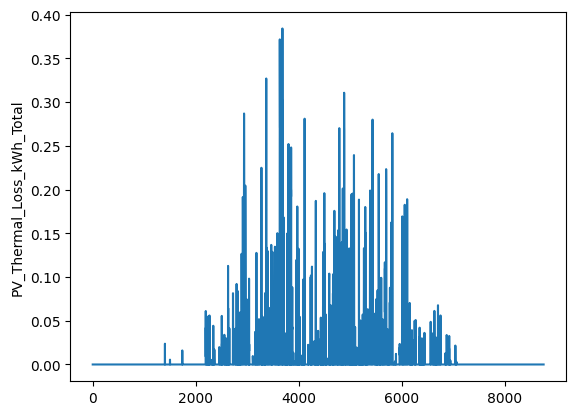

In [37]:
sns.lineplot(pv_model.all_models["PV_Thermal_Loss_kWh_Total"])

In [38]:
temp_losses = (pv_model.all_models["PV_Thermal_Loss_kWh_Total"].sum() / pv_model.all_models["PV_Gen_kWh_Total"].sum() * 100)

print(f"{round(temp_losses, 3)}% change to power due to temperature losses")

0.778% change to power due to temperature losses


In [39]:
pv_model.models[0]["model_result"]

,Hour_of_Day,Day_of_Year,Week_of_Year,Month_of_Year,T2m,Declination_Angle,Solar_Time,Hour_Angle,AOI,Zenith_Angle,...,E_Diffuse_Wm2,E_Ground_Wm2,E_POA_Wm2,Panel_POA_Wm2,IAM_Loss_Wm2,ET_HRad_Wm2,PV_Derated_Eff,Array_Temp_C,PV_Gen_kWh,PV_Thermal_Loss_kWh
0,0,1,1,1,3.070,-23.012,0.056,-179.155,133.623,148.401,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,3.070,0.000,0.000
1,1,1,1,1,2.630,-23.012,1.056,-164.155,122.480,146.257,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2.630,0.000,0.000
2,2,1,1,1,2.180,-23.012,2.056,-149.155,111.426,140.931,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2.180,0.000,0.000
3,3,1,1,1,1.730,-23.012,3.056,-134.155,100.747,133.633,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.730,0.000,0.000
4,4,1,1,1,1.280,-23.012,4.056,-119.155,90.730,125.337,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.280,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,19,365,52,12,5.310,-23.086,19.064,105.958,152.766,117.784,...,0.000,0.000,0.000,0.000,0.000,0.000,0.995,5.310,0.000,0.000
8756,20,365,52,12,4.860,-23.086,20.064,120.958,159.857,126.422,...,0.000,0.000,0.000,0.000,0.000,0.000,0.995,4.860,0.000,0.000
8757,21,365,52,12,4.410,-23.086,21.064,135.958,160.457,134.640,...,0.000,0.000,0.000,0.000,0.000,0.000,0.995,4.410,0.000,0.000
8758,22,365,52,12,3.970,-23.086,22.064,150.958,154.101,141.765,...,0.000,0.000,0.000,0.000,0.000,0.000,0.995,3.970,0.000,0.000


In [40]:
pv_model.all_models

,E_Beam_Wm2_Array_1,E_Diffuse_Wm2_Array_1,E_Ground_Wm2_Array_1,E_POA_Wm2_Array_1,Panel_POA_Wm2_Array_1,ET_HRad_Wm2_Array_1,Array_Temp_C_Array_1,PV_Gen_kWh_Array_1,PV_Thermal_Loss_kWh_Array_1,IAM_Loss_Wm2_Array_1,...,PV_Thermal_Loss_kWh_Total,IAM_Loss_Wm2_Total,Declination_Angle,Solar_Time,Hour_Angle,T2m,Hour_of_Day,Day_of_Year,Week_of_Year,Month_of_Year
0,0.000,0.000,0.000,0.000,0.000,0.000,3.070,0.000,0.000,0.000,...,0.000,0.000,-23.012,0.056,-179.155,3.070,0,1,1,1
1,0.000,0.000,0.000,0.000,0.000,0.000,2.630,0.000,0.000,0.000,...,0.000,0.000,-23.012,1.056,-164.155,2.630,1,1,1,1
2,0.000,0.000,0.000,0.000,0.000,0.000,2.180,0.000,0.000,0.000,...,0.000,0.000,-23.012,2.056,-149.155,2.180,2,1,1,1
3,0.000,0.000,0.000,0.000,0.000,0.000,1.730,0.000,0.000,0.000,...,0.000,0.000,-23.012,3.056,-134.155,1.730,3,1,1,1
4,0.000,0.000,0.000,0.000,0.000,0.000,1.280,0.000,0.000,0.000,...,0.000,0.000,-23.012,4.056,-119.155,1.280,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.000,0.000,0.000,0.000,0.000,0.000,5.310,0.000,0.000,0.000,...,0.000,0.000,-23.086,19.064,105.958,5.310,19,365,52,12
8756,0.000,0.000,0.000,0.000,0.000,0.000,4.860,0.000,0.000,0.000,...,0.000,0.000,-23.086,20.064,120.958,4.860,20,365,52,12
8757,0.000,0.000,0.000,0.000,0.000,0.000,4.410,0.000,0.000,0.000,...,0.000,0.000,-23.086,21.064,135.958,4.410,21,365,52,12
8758,0.000,0.000,0.000,0.000,0.000,0.000,3.970,0.000,0.000,0.000,...,0.000,0.000,-23.086,22.064,150.958,3.970,22,365,52,12


In [41]:
pv_model.combined_model

,E_Beam_Wm2_Total,E_Diffuse_Wm2_Total,E_Ground_Wm2_Total,E_POA_Wm2_Total,Panel_POA_Wm2_Total,ET_HRad_Wm2_Total,Array_Temp_C_Avg,PV_Gen_kWh_Total,PV_Thermal_Loss_kWh_Total,IAM_Loss_Wm2_Total,Declination_Angle,Solar_Time,Hour_Angle,T2m,Hour_of_Day,Day_of_Year,Week_of_Year,Month_of_Year
0,0.000,0.000,0.000,0.000,0.000,0.000,3.070,0.000,0.000,0.000,-23.012,0.056,-179.155,3.070,0,1,1,1
1,0.000,0.000,0.000,0.000,0.000,0.000,2.630,0.000,0.000,0.000,-23.012,1.056,-164.155,2.630,1,1,1,1
2,0.000,0.000,0.000,0.000,0.000,0.000,2.180,0.000,0.000,0.000,-23.012,2.056,-149.155,2.180,2,1,1,1
3,0.000,0.000,0.000,0.000,0.000,0.000,1.730,0.000,0.000,0.000,-23.012,3.056,-134.155,1.730,3,1,1,1
4,0.000,0.000,0.000,0.000,0.000,0.000,1.280,0.000,0.000,0.000,-23.012,4.056,-119.155,1.280,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.000,0.000,0.000,0.000,0.000,0.000,5.310,0.000,0.000,0.000,-23.086,19.064,105.958,5.310,19,365,52,12
8756,0.000,0.000,0.000,0.000,0.000,0.000,4.860,0.000,0.000,0.000,-23.086,20.064,120.958,4.860,20,365,52,12
8757,0.000,0.000,0.000,0.000,0.000,0.000,4.410,0.000,0.000,0.000,-23.086,21.064,135.958,4.410,21,365,52,12
8758,0.000,0.000,0.000,0.000,0.000,0.000,3.970,0.000,0.000,0.000,-23.086,22.064,150.958,3.970,22,365,52,12


In [42]:
pv_model.summary

PV_Gen_kWh_Annual                6616.109
PV_Gen_kWh_Lifetime            155081.589
E_POA_Wm2_Annual              4781110.369
Panel_POA_Wm2_Annual          4723037.178
IAM_Loss_Wm2_Annual             58073.191
PV_Thermal_Loss_kWh_Annual         51.480
E_Beam_Wm2_Annual             2108154.842
E_Diffuse_Wm2_Annual          2587621.031
E_Ground_Wm2_Annual             85334.496
ET_HRad_Wm2_Annual           11352896.361
Array_Temp_C_Avg                   11.311
T2m_Avg                             8.899
dtype: float64

In [43]:
pv_model.summary_grouped.daily

,PV_Gen_kWh_Total,E_POA_Wm2_Total,Panel_POA_Wm2_Total,IAM_Loss_Wm2_Total,PV_Thermal_Loss_kWh_Total,E_Beam_Wm2_Total,E_Diffuse_Wm2_Total,E_Ground_Wm2_Total,ET_HRad_Wm2_Total,Array_Temp_C_Avg,T2m
Day_of_Year,,,,,,,,,,,
1,0.766,541.049,541.049,0.000,0.000,0.000,529.566,11.484,6910.298,1.513,1.417
2,2.633,1893.722,1860.705,33.017,0.000,716.094,1147.508,30.120,6976.615,2.824,2.522
3,2.515,1811.135,1777.336,33.799,0.000,739.788,1042.864,28.484,7058.225,2.005,1.600
4,4.294,3118.786,3034.957,83.829,0.000,1688.253,1388.215,42.318,7145.903,3.270,2.676
5,5.168,3780.549,3652.521,128.029,0.000,2317.109,1414.562,48.879,7239.617,2.803,2.215
...,...,...,...,...,...,...,...,...,...,...,...
361,6.092,4489.231,4325.870,163.361,0.000,2972.585,1463.567,53.079,6688.089,4.477,3.663
362,4.932,3614.854,3502.413,112.441,0.000,2055.148,1511.782,47.925,6721.583,5.355,4.654
363,2.409,1743.230,1710.458,32.772,0.000,612.907,1102.292,28.031,6760.562,5.824,5.499


In [44]:
pv_model.summary

PV_Gen_kWh_Annual                6616.109
PV_Gen_kWh_Lifetime            155081.589
E_POA_Wm2_Annual              4781110.369
Panel_POA_Wm2_Annual          4723037.178
IAM_Loss_Wm2_Annual             58073.191
PV_Thermal_Loss_kWh_Annual         51.480
E_Beam_Wm2_Annual             2108154.842
E_Diffuse_Wm2_Annual          2587621.031
E_Ground_Wm2_Annual             85334.496
ET_HRad_Wm2_Annual           11352896.361
Array_Temp_C_Avg                   11.311
T2m_Avg                             8.899
dtype: float64

In [45]:
pv_model.summary_grouped.monthly

,PV_Gen_kWh_Total,E_POA_Wm2_Total,Panel_POA_Wm2_Total,IAM_Loss_Wm2_Total,PV_Thermal_Loss_kWh_Total,E_Beam_Wm2_Total,E_Diffuse_Wm2_Total,E_Ground_Wm2_Total,ET_HRad_Wm2_Total,Array_Temp_C_Avg,T2m
Month_of_Year,,,,,,,,,,,
1,155.333,112921.434,109800.896,3120.538,0.000,62819.463,48552.411,1549.560,275166.987,4.525,3.964
2,270.351,195076.221,191196.730,3879.490,0.024,99588.264,92487.599,3000.358,448069.696,7.044,5.736
3,315.773,225244.836,223398.273,1846.563,0.025,60474.138,160759.631,4011.068,858420.687,4.604,3.241
4,797.726,572169.800,565804.931,6364.869,1.778,266448.972,295447.127,10273.701,1238403.791,10.353,6.774
5,1054.165,761183.940,753272.211,7911.730,9.816,361773.946,385229.656,14180.338,1620269.826,15.458,11.035
6,933.774,676364.844,670081.129,6283.715,12.338,276698.660,386753.287,12912.897,1716717.365,17.415,13.222
7,914.885,661807.101,656065.584,5741.517,11.035,237229.902,411995.517,12581.683,1696427.333,18.302,14.425
8,891.899,647332.754,640325.660,7007.094,11.441,287069.824,348478.786,11784.143,1404893.782,17.901,13.902
9,587.963,425088.966,419863.256,5225.710,4.141,192018.574,225695.164,7375.228,967320.610,15.261,12.699


# ***MODEL ANALYSIS***